# Uncertainty quantification

This colab notebook is intended to provide an interactive example of uncertainty quantification using the example of a double pendulum (epistemic uncertainty) and rain drops (aleatory uncertainty).

A double pendulum is well known for it's highly sensitive and "chaotic" behaviour. It is however described precisely by differential equations, and it is the extreme sensitivity that makes it appear so chaotic. 

The basis for the functions for the double pendulum is entirely from Jake VanderPlas, originally posted here: https://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/.

The rain drop simulation is originally from https://matplotlib.org/3.3.2/gallery/animation/rain.html created by Nicolas P. Rougier. 

## Double Pendulum

First let make our imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

from IPython.display import HTML

from statsmodels.distributions.empirical_distribution import ECDF

from matplotlib import collections
from matplotlib import animation


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# set the random generator seed so you will get the same "random" results as me
np.random.seed(42)

Then we can define a function for our pendulum (which is generalised to be 'n' sections. We'll only use n=2 for a double pendulum in this notebook however.

In [3]:
def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

We need a little helper function to convert from radial positions to x, y positions.

In [4]:
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

And now we can define a time list, t, in this case 10 seconds, and solve the pendulum equations of motion.

In [5]:
t = np.linspace(0, 10, 1000)
p = integrate_pendulum(n=2, times=t, initial_positions=135)


Since this notebook is interested in a double pendulum example, we can slice the solved pendulum results to obtain the angular velocity of the 2nd mass. This angular velocity will be our output variable of interest. 

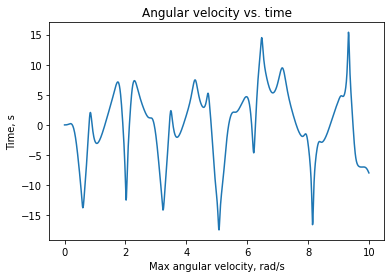

In [6]:
plt.plot(t,p[:, 3:4])
plt.title("Angular velocity vs. time")
plt.xlabel("Max angular velocity, rad/s")
plt.ylabel("Time, s")
plt.show()

We can find the maximum absolute value, to give us a single output parameter of interest.

In [7]:
print(f"The maximum absolute angular velocity of the 2nd mass is {max(p[:, 3:4].max(),-p[:, 3:4].min()):.2f} rad/s")

The maximum absolute angular velocity of the 2nd mass is 17.45 rad/s


In [8]:
%%time

# Monte Carlo

NUM_RUNS=1000

runs = []
angles = []

for i in range(NUM_RUNS):
    angle_i = np.random.normal(loc=135., scale=0.001)
    p = integrate_pendulum(n=2, times=t, initial_positions=angle_i)
    runs.append(max(p[:, 3:4].max(),-p[:, 3:4].min())) 
    angles.append(angle_i)



CPU times: user 5min 48s, sys: 442 ms, total: 5min 49s
Wall time: 5min 48s


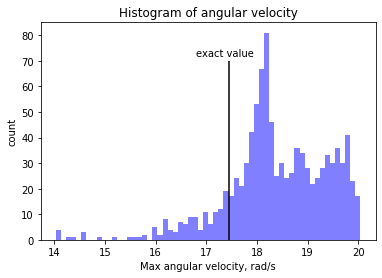

In [9]:
# plotting

plt.hist(runs, 60, facecolor='blue', alpha=0.5)
plt.vlines(17.45,0,70)
plt.text(16.8, 72, 'exact value')
plt.title("Histogram of angular velocity")
plt.xlabel("Max angular velocity, rad/s")
plt.ylabel("count")
plt.show()

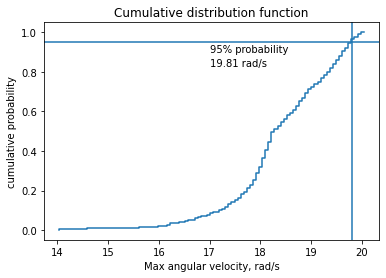

In [10]:
ecdf = ECDF(runs)
x = np.linspace(min(runs), max(runs), 100)
y = ecdf(x)
plt.step(x, y)
plt.title("Cumulative distribution function")
plt.xlabel("Max angular velocity, rad/s")
plt.ylabel("cumulative probability")

plt.axvline(np.interp(0.95,y,x))
plt.axhline(0.95)
plt.text(17, 0.9, '95% probability')
plt.text(17, 0.83, f'{np.interp(0.95,y,x):.2f} rad/s')

plt.show()

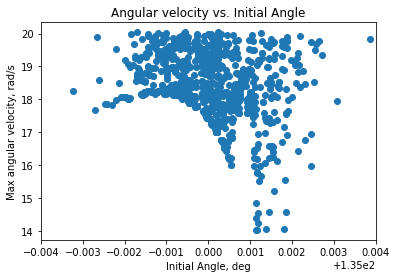

In [11]:
plt.scatter(angles, runs)
plt.title("Angular velocity vs. Initial Angle")
plt.ylabel("Max angular velocity, rad/s")
plt.xlabel("Initial Angle, deg")
plt.xlim(134.996,135.004)
plt.show()

Now to check some animations:

In [12]:
def animate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
  
    p = integrate_pendulum(n, times,
                       initial_positions=initial_positions,
                       initial_velocities=initial_velocities,
                       lengths=lengths, masses=masses)
    x, y = get_xy_coords(p)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(times),
                                   interval=1000 * times.max() / len(times),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [13]:
def animate_pendulum_multiple(n, times=t, n_pendulums=100, track_length=15):
    oversample = 3
    track_length *= oversample
    
    t = np.linspace(0, 10, oversample * 200)
    p = [integrate_pendulum(n, t, initial_positions=np.random.normal(loc=135., scale=0.001))
         for i in range(n_pendulums)]
    positions = np.array([get_xy_coords(pi) for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    # positions is a 4D array: (npendulums, len(t), n+1, xy)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    track_segments = np.zeros((n_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='jet')
    tracks.set_array(np.linspace(0, 1, n_pendulums))
    ax.add_collection(tracks)
    
    points, = plt.plot([], [], 'ok')
    
    pendulum_segments = np.zeros((n_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((n_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((n_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim
    
anim = animate_pendulum_multiple(2, times=t)


In [14]:
HTML(anim.to_html5_video()) 

# or, if FFMPEG is not installed then comment the above line and uncomment the lines below:
#plt.rcParams["animation.writer"] = 'html'
#anim.save('double_pendulum_multiple.html', extra_args=['-vcodec', 'libx264'])
#HTML(filename="double_pendulum_multiple.html")


## Rain Drops

This example explores the inherent randomness of rain drops.

In [15]:
# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 100
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = 10

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 2
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = 10

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


    
plt.close(fig)
    


# Construct the animation, using the update function as the animation director.
anim = animation.FuncAnimation(fig, update, interval=10, frames=1000)

#animate
HTML(anim.to_html5_video()) 

# or, if FFMPEG is not installed then comment the above line and uncomment the lines below:
#anim.save('raindrops.html', extra_args=['-vcodec', 'libx264'])
#HTML(filename="raindrops.html")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  if sys.path[0] == '':
